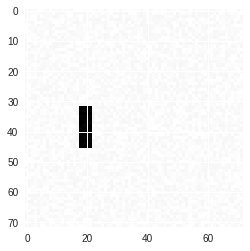

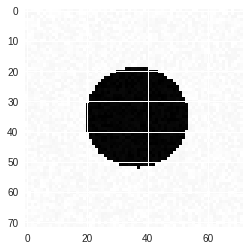

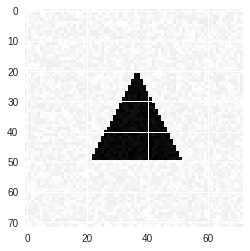

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    #Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




# Other utilities functions

In [0]:
def debug(model):
  X_test = generate_a_disk()
  X_test = X_test.reshape(1, X_test.shape[0])
  print(model.predict(X_test))
  
def test(model, X_test, Y_test):
  loss, acc = model.evaluate(X_test, Y_test)
  print("Test Loss : "+str(loss)+", Test Accuracy : "+str(acc))
  
def plotLossAcc(loss, accuracy):
  plt.subplot(121)
  plt.title("Train Loss")
  plt.xlabel("Epoch")
  plt.plot(loss)
  plt.subplot(122)
  plt.title("Train Acc")
  plt.xlabel("Epoch")
  plt.plot(accuracy)
  plt.show()
  
def train(model, X_train, Y_train, optimizer, batch_size, epochs, loss_train='categorical_crossentropy'):
  model.compile(loss=loss_train,
                optimizer=optimizer,
                metrics=['accuracy'])
  hist = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)
  loss = hist.history['loss']
  accuracy = hist.history['acc']
  return model, loss, accuracy

def run(model, X_train, Y_train, X_test, Y_test, optimizer, batch_size, epochs):
  model, loss, accuracy = train(model, X_train, Y_train, optimizer, batch_size, epochs)
  plotLossAcc(loss, accuracy)
  test(model, X_test, Y_test)

# Load keras with tensorflow backend

In [104]:
from keras.models import Sequential
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16981052758859505557
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11588339380944803861
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4391025546783059624
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13640794846279479205
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# 3) Simple Classification

In [105]:
from keras.utils import to_categorical

num_classes = 3

[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = to_categorical(Y_train, num_classes=num_classes, dtype='float32')

[X_test, Y_test] = generate_test_set_classification()
Y_test = to_categorical(Y_test, num_classes=num_classes, dtype='float32')


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


## Linear classifier

In [0]:
from keras.layers import Dense
from keras.models import Sequential

def linearClassifier():
  model = Sequential()
  model.add(Dense(units=num_classes, activation="softmax"))
  return model

  

### SGD

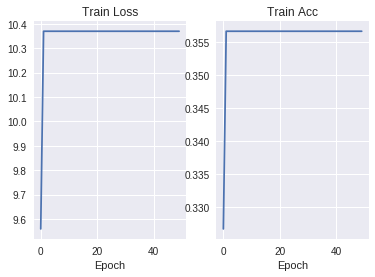

300/300 [==============================] - 1s 2ms/step
Test Loss : 10.637942822774251, Test Accuracy : 0.34000000009934106


In [109]:
model_sgd = linearClassifier()
run(model_sgd, X_train, Y_train, X_test, Y_test, "sgd", batch_size=16, epochs=50)

## Adam

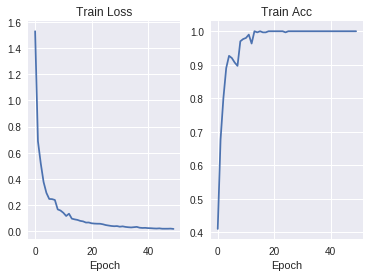

300/300 [==============================] - 1s 2ms/step
Test Loss : 3.5761964734395346, Test Accuracy : 0.3766666658719381


In [110]:
model_adam = linearClassifier()
run(model_adam, X_train, Y_train, X_test, Y_test, "adam", batch_size=32, epochs=50)

The model is clearly overfitting

# 4) Visualization of the Solution

In [0]:
def visualize(model, nb_class):
    matrix = np.array(model.get_weights()[0]).astype("float").reshape(IMAGE_SIZE, IMAGE_SIZE, nb_class)
    plt.imshow(matrix[:,:,0])
    plt.show()
    plt.imshow(matrix[:,:,1])
    plt.show()
    plt.imshow(matrix[:,:,2])
    plt.show()

## SGD

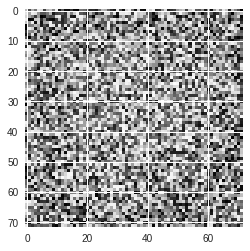

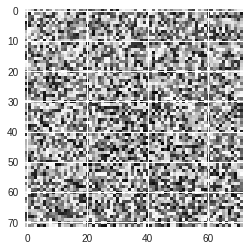

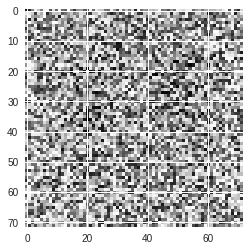

In [113]:
visualize(model_sgd, 3)

## Adam

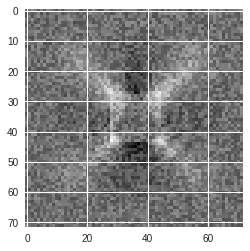

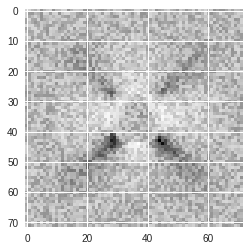

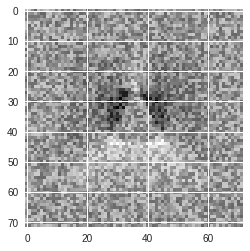

In [114]:
visualize(model_adam, 3)

# 5) A More Difficult Classification Problem

In [115]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE)
X_train = np.expand_dims(X_train, axis=3)
Y_train = to_categorical(Y_train, num_classes=num_classes, dtype='float32')

[X_test, Y_test] = generate_test_set_classification()
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE)
X_test = np.expand_dims(X_test, axis=3)
Y_test = to_categorical(Y_test, num_classes=num_classes, dtype='float32')

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


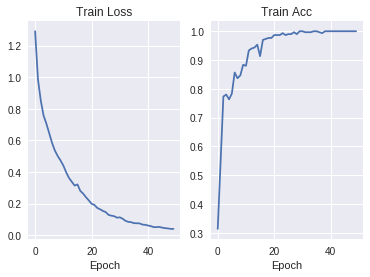

300/300 [==============================] - 1s 3ms/step
Test Loss : 0.7990929953257243, Test Accuracy : 0.6733333325386047


In [116]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten

def convolutionalClassifier():
  model = Sequential()
  model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(units=num_classes, activation="softmax"))
  return model

model = convolutionalClassifier()
run(model, X_train, Y_train, X_test, Y_test, "adam", batch_size=32, epochs=50)

# 6) A Regression Problem

In [117]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE)
X_train = np.expand_dims(X_train, axis=3)

[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE)
X_test = np.expand_dims(X_test, axis=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


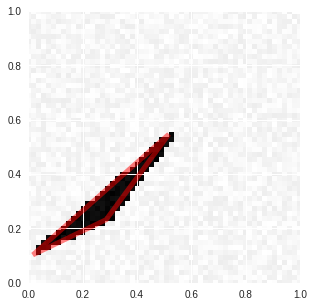

In [118]:
visualize_prediction(X_train[0], Y_train[0])

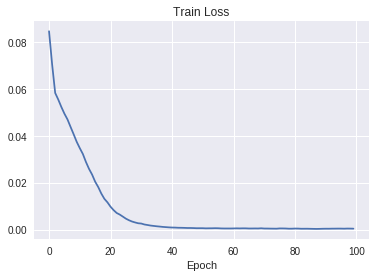

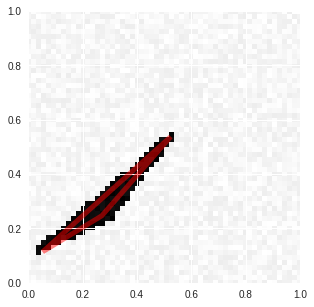

In [119]:

def runRegressor(model, X_train, Y_train, X_test, Y_test, optimizer, batch_size, epochs):
  model, loss, accuracy = train(model, X_train, Y_train, optimizer, batch_size, epochs, loss_train='mean_squared_error')
  plt.title("Train Loss")
  plt.xlabel("Epoch")
  plt.plot(loss)
  visualize_prediction(X_train[0], model.predict(np.array([X_train[0]]), batch_size=1)[0])

def regressor():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(16, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(units=6, activation='sigmoid'))
  return model

model = regressor()
runRegressor(model, X_train, Y_train, X_test, Y_test, "adam", batch_size=16, epochs=100)

# 7) Image Denoising

In [0]:
def addRandomNoise(imdata, max_noise):
  noise = np.random.uniform(50., max_noise)
  return np.maximum(np.minimum(imdata + noise * np.random.uniform(-1,1, imdata.size), np.ones(imdata.size)*255.), np.zeros(imdata.size))

def generate_dataset_denoising(nb_samples, max_noise, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            Y[i] = generate_a_rectangle(0, free_location)
        elif category == 1: 
            Y[i] = generate_a_disk(0, free_location)
        else:
            [Y[i], V] = generate_a_triangle(0, free_location)
        X[i] = addRandomNoise(Y[i], max_noise)
    return [X, Y]

def generate_test_set_denoising(max_noise):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, max_noise, True)
    return [X_test, Y_test]

In [152]:
max_noise = 100.

[X_train, Y_train] = generate_dataset_denoising(300, max_noise, free_location=True)
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE)
Y_train = Y_train.reshape(Y_train.shape[0], IMAGE_SIZE, IMAGE_SIZE)
X_train = np.expand_dims(X_train, axis=3)
Y_train = np.expand_dims(Y_train, axis=3)

[X_test, Y_test] = generate_test_set_denoising(max_noise)
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE)
Y_test = Y_test.reshape(Y_test.shape[0], IMAGE_SIZE, IMAGE_SIZE)
X_test = np.expand_dims(X_test, axis=3)
Y_test = np.expand_dims(Y_test, axis=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


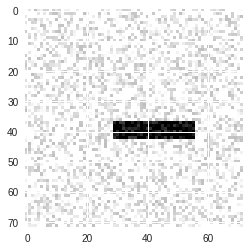

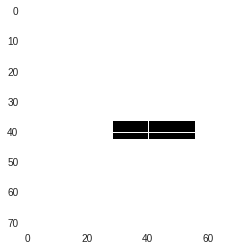

In [153]:
plt.imshow(X_train[0][:, :, 0], cmap='gray')
plt.show()
plt.imshow(Y_train[0][:, :, 0], cmap='gray')
plt.show()

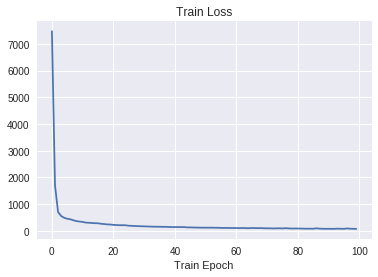

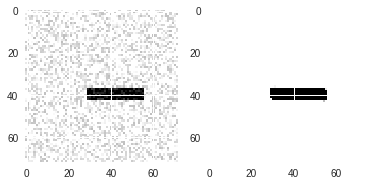

In [157]:
from keras.layers import UpSampling2D
from keras.layers import Activation
from keras import backend as K

def extendedSigmoid(x):
    return (K.sigmoid(x) * 255.)

def visualizeDenoised(im_noisy, im):
  plt.subplot(121)
  plt.imshow(im_noisy, cmap='gray')
  plt.subplot(122)
  plt.imshow(im, cmap='gray')
  plt.show()
  

def runDenoising(model, X_train, Y_train, X_test, Y_test, optimizer, batch_size, epochs):
  model, loss, accuracy = train(model, X_train, Y_train, optimizer, batch_size, epochs, loss_train='mean_squared_error')
  plt.title("Train Loss")
  plt.xlabel("Train Epoch")
  plt.plot(loss)
  plt.show()
  visualizeDenoised(X_train[0,:,:,0], model.predict(np.array([X_train[0]]), batch_size=1)[0,:,:,0])

def denoising():
  model = Sequential()
  
  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(8, (5, 5), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
  model.add(Conv2D(8, (5, 5), activation='relu', padding="same"))
  model.add(UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
  
  model.add(Conv2D(1, (3, 3), padding="same"))
  model.add(Activation(extendedSigmoid))
  
  return model

model = denoising()
runDenoising(model, X_train, Y_train, X_test, Y_test, "adam", batch_size=16, epochs=100)